# 0. 环境准备

* python >= 3.7
* pandas >= 1.1.3
* numpy >= 1.19.2
* prophet 1.0
* matplotlib >= 3.3.2
* jupyter_nbextensions_configurator （非必须， 推荐安装）

In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置pandas可以显示的行数和列数
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# 忽略warnings
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# 1. 数据探索和清洗

## 1.1. 数据和字段含义

In [2]:
# cashflow_data: 每家子公司/每天/每种中类型的现金流入和流出数据
## date: 日期
## cashflow_category: 现金流类型-父类
## cashflow_subcategory: 现金流类型-子类
## cashflow: 现金流
## branch_id: 子公司ID
cashflow_data = pd.read_csv('data/cashflow_data.csv', parse_dates=['date'])
cashflow_data.head(2)

,date,cashflow_category,cashflow_subcategory,cashflow,branch_id
0,2015-04-01,cash_in,sales,275765.184075,1
1,2015-04-02,cash_in,sales,255256.272380,1


In [3]:
# 查看cashflow_category和cashflow_subcategory的范围
## sales: 营业额收入
## invest & interest: 投资本金和利息收入
## invest: 投资支出
## rent & utility: 房租和基础设施（水电、物业费）支出
## labor: 员工薪资支出
## material cost: 食品和包装原料支出
cashflow_data[['cashflow_category','cashflow_subcategory']].drop_duplicates().sort_values('cashflow_category')

,cashflow_category,cashflow_subcategory
0,cash_in,sales
22,cash_in,invest & interest
10,cash_out,rent & utility
16,cash_out,invest
28,cash_out,labor
114,cash_out,material cost


## 1.2. 查看数据范围

In [4]:
# 查看每种类型的现金流的取值范围
cashflow_range = cashflow_data.groupby(['cashflow_category', 'cashflow_subcategory'])['cashflow'].describe()
cashflow_range

count          mean           std  \
cashflow_category cashflow_subcategory                                        
cash_in           invest & interest       828.0  2.886147e+07  5.574075e+07   
                  sales                 11314.0  4.493729e+05  5.606483e+05   
cash_out          invest                  865.0 -2.795206e+07  5.408256e+07   
                  labor                   372.0 -3.681293e+06  4.270054e+06   
                  material cost           117.0 -8.099319e+06  7.743611e+06   
                  rent & utility          372.0 -4.310711e+06  6.021050e+06   

                                                 min           25%  \
cashflow_category cashflow_subcategory                               
cash_in           invest & interest    -3.950525e+05  7.170246e+05   
                  sales                 1.649694e+03  1.540502e+04   
cash_out          invest               -4.230950e+08 -2.870000e+07   
                  labor                -1.654231e+07 -6.459515e+06   
                  material cost        -2.416533e+07 -1.409979e+07   
                  rent & utility       -2.238231e+07 -6.270923e+06   

                                                 50%           75%  \
cashflow_category cashflow_subcategory                               
cash_in           invest & interest     7.651270e+06  2.927744e+07   
                  sales                 2.568751e+05  6.914913e+05   
cash_out          invest               -7.420000e+06 -7.000000e+05   
                  labor                -1.698678e+06 -1.146123e+05   
                  material cost        -7.605892e+06 -5.782619e+05   
                  rent & utility       -2.336709e+06 -1.071718e+05   

                                                 max  
cashflow_category cashflow_subcategory                
cash_in           invest & interest     4.231065e+08  
                  sales                 2.736065e+06  
cash_out          invest                3.950000e+05  
                  labor                -1.764100e+04  
                  material cost        -9.784271e+04  
                  rent & utility       -2.383361e+04

结论：
1. cash_in对应的现金流为正， cash_out对用的现金流为负
2. sales的数据两最多，其余类型的现金流数据比较少
3. 数据分布比较合理，没有发现异常大或小的数字

In [5]:
# 查看历史数据的时间范围
print( cashflow_data['date'].min(), cashflow_data['date'].max() )

2015-04-01 00:00:00 2018-02-28 00:00:00


## 1.3. 是否存在缺失值

In [6]:
# 是否有na值
cashflow_data[ cashflow_data['cashflow'].isna() ].shape[0]

0

In [7]:
# 是否每天都有数据
date_begin = cashflow_data['date'].min()
date_end = cashflow_data['date'].max()
date_count = len( cashflow_data['date'].unique() )

date_miss = (date_end - date_begin).days + 1 - date_count
print( date_miss )

0


In [8]:
# 是否每个子公司每天都有数据
branch_date_range = cashflow_data.groupby(['branch_id'])['date'].agg(['min','max','nunique']).reset_index()
branch_date_range.columns = ['branch_id', 'date_begin', 'date_end', 'date_count']
branch_date_range['date_miss'] = (branch_date_range['date_end']-branch_date_range['date_begin']
                                 ).dt.days + 1 - branch_date_range['date_count']
branch_date_range.describe()

,branch_id,date_count,date_miss
count,14.0000,14.000000,14.0
mean,7.5000,808.142857,0.0
std,4.1833,374.347814,0.0
min,1.0000,120.000000,0.0
25%,4.2500,493.250000,0.0
50%,7.5000,1065.000000,0.0
75%,10.7500,1065.000000,0.0
max,14.0000,1065.000000,0.0


结论：
1. 每家子公司都没有缺失的日期
2. 每家子公司的历史数据长度不一致（经验证，是正常现象，历史数据短的是比较新的子公司）

In [9]:
# 是否每个子公司的每种现金类型每天都有数据
subcat_date_range = cashflow_data.groupby(['branch_id','cashflow_subcategory'])['date'].agg(['min','max','nunique']).reset_index()
subcat_date_range.columns = ['branch_id','cashflow_subcategory', 'date_begin', 'date_end', 'date_count']
subcat_date_range['date_miss'] = (subcat_date_range['date_end']-subcat_date_range['date_begin']
                                 ).dt.days + 1 - subcat_date_range['date_count']
subcat_date_range.describe()

,branch_id,date_count,date_miss
count,82.000000,82.000000,82.000000
mean,7.365854,169.121951,614.012195
std,4.010825,329.457406,410.346872
min,1.000000,1.000000,0.000000
25%,4.000000,12.000000,150.250000
50%,7.000000,35.000000,903.000000
75%,11.000000,103.000000,970.250000
max,14.000000,1065.000000,1003.000000


In [10]:
subcat_date_range.groupby(['cashflow_subcategory'])['date_miss'].agg(['min','max'])

,min,max
cashflow_subcategory,,
invest,157,998
invest & interest,146,1003
labor,89,1003
material cost,0,903
rent & utility,87,1003
sales,0,0


结论：
1. 每家子公司每天都有sales数据
2. 其余类型的现金流数据不是每天都有。（经验证，是正常现象）

## 1.4. 是否存在主键重复的数据

In [11]:
cashflow_data.shape[0] == cashflow_data[['date','branch_id','cashflow_subcategory']].drop_duplicates().shape[0]

True

结论：
没有重复数据

## 1.5. 数据规律

In [12]:
# 以sales最高的公司为例，分析不同现金流的规律
total_sales = cashflow_data[ cashflow_data['cashflow_subcategory']=='sales' 
                           ].groupby(['branch_id'])[ 'cashflow' ].sum().reset_index().rename(columns={'cashflow':'total_sales'})
total_sales = total_sales.sort_values( 'total_sales', ascending=False )

sample_branch = total_sales.iloc[0]['branch_id']
sample_branch

5.0

### 1.5.1. sales数据的规律

No handles with labels found to put in legend.


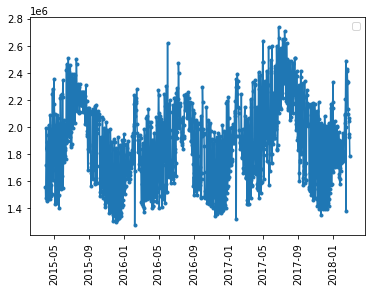

In [13]:
# 整体规律
plot_data = cashflow_data[ (cashflow_data['cashflow_subcategory']=='sales') & 
                         (cashflow_data['branch_id']==sample_branch)
                         ].sort_values('date')
plt.plot( plot_data['date'], plot_data['cashflow'], '.-' )
plt.xticks(rotation=90)
plt.legend()

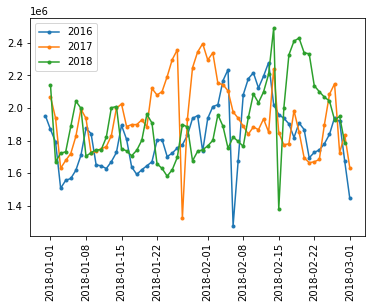

In [14]:
# 在春节期间的sales的变化
for year in [2016, 2017, 2018]:
    plot_date_begin = str(year)+'-01-01'
    plot_date_end = str(year) + '-03-01'
    
    plot_data = cashflow_data[ ( cashflow_data['cashflow_subcategory']=='sales') & 
                              ( cashflow_data['branch_id']==sample_branch ) & 
                              ( cashflow_data['date'] >= plot_date_begin ) & 
                             ( cashflow_data['date']<=plot_date_end )
                             ].sort_values('date')
    plot_data['date_plot'] = plot_data['date'] + pd.Timedelta( (2018-year)*365, unit='D' )
    
    plt.plot( plot_data['date_plot'], plot_data['cashflow'], '.-', label=str(year) )
plt.xticks(rotation=90)
plt.legend()

No handles with labels found to put in legend.


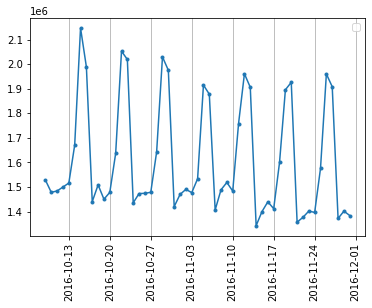

In [15]:
# weekly sales的变化
plot_data = cashflow_data[ ( cashflow_data['cashflow_subcategory']=='sales') & 
                              ( cashflow_data['branch_id']==sample_branch ) & 
                              ( cashflow_data['date'] >= '2016-10-09' ) & 
                             ( cashflow_data['date']<= '2016-11-30' )
                             ].sort_values('date')
plt.plot( plot_data['date'], plot_data['cashflow'], '.-' )

## 以7为周期绘制x轴的网格线，更容易看清weekly的周期性
plt.grid( axis='x' )
ax = plt.gca()
x_major_locator=plt.MultipleLocator(7)
ax.xaxis.set_major_locator(x_major_locator)
## 让横轴标签垂直显示
plt.xticks(rotation=90)
plt.legend()

结论：
1. sales数据有很强的以年为单位和以周为单位的周期性
2. sales数据存在趋势的变化
3. 初期和年初一对sales有很大的影响

###  1.5.2. labor 数据的规律

No handles with labels found to put in legend.


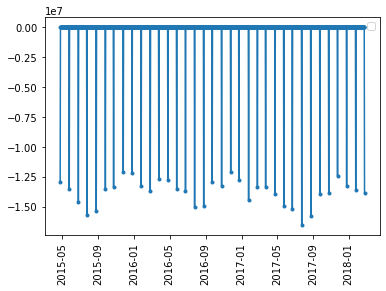

In [16]:
# 整体规律
plot_data = cashflow_data[ (cashflow_data['cashflow_subcategory']=='labor') & 
                         (cashflow_data['branch_id']==sample_branch)
                         ].sort_values('date')

# 不是每天都有数据。为了更好得可视化数据的规律，没有数据的地方有0填充
full_data = pd.DataFrame({'date':pd.date_range( plot_data['date'].min(), plot_data['date'].max() )})
plot_data = pd.merge( full_data, plot_data[['date', 'cashflow']], how='left' )
plot_data.fillna(0, inplace=True)

plt.plot( plot_data['date'], plot_data['cashflow'], '.-' )
plt.xticks(rotation=90)
plt.legend()

结论：
1. labor一个月只有一天是有数据的 （经验证，每个子公司的发薪日都是每月25号，如果25号是放假日，那么提前到上一个上班日）。
2. 对于labor数据，是否是发薪日是个重要特征
3. labor数据还有很强的以年为单位的季节性

### 1.5.3. material cost数据的规律

No handles with labels found to put in legend.


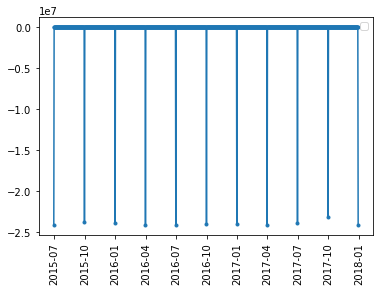

In [17]:
# 整体规律
plot_data = cashflow_data[ (cashflow_data['cashflow_subcategory']=='material cost') & 
                         (cashflow_data['branch_id']==sample_branch)
                         ].sort_values('date')

# 不是每天都有数据。为了更好得可视化数据的规律，没有数据的地方有0填充
full_data = pd.DataFrame({'date':pd.date_range( plot_data['date'].min(), plot_data['date'].max() )})
plot_data = pd.merge( full_data, plot_data[['date', 'cashflow']], how='left' )
plot_data.fillna(0, inplace=True)

plt.plot( plot_data['date'], plot_data['cashflow'], '.-' )
plt.xticks(rotation=90)
plt.legend()

结论：

1. material cost 一个季度只有一天是有数据的 （经验证，每个子公司在每个季度的最后一天给供应商打款，如果那一天是节假日，那么提前到上一个上班日）。
2. 对于material cost数据，是否是付款日是个重要特征
3. material cost的周期性比较弱

### 1.5.4. rent & utility 数据的规律

No handles with labels found to put in legend.


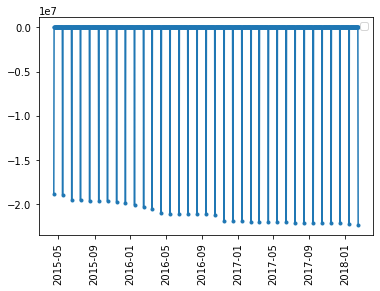

In [18]:
# 整体规律
plot_data = cashflow_data[ (cashflow_data['cashflow_subcategory']=='rent & utility') & 
                         (cashflow_data['branch_id']==sample_branch)
                         ].sort_values('date')

# 不是每天都有数据。为了更好得可视化数据的规律，没有数据的地方有0填充
full_data = pd.DataFrame({'date':pd.date_range( plot_data['date'].min(), plot_data['date'].max() )})
plot_data = pd.merge( full_data, plot_data[['date', 'cashflow']], how='left' )
plot_data.fillna(0, inplace=True)

plt.plot( plot_data['date'], plot_data['cashflow'], '.-' )
plt.xticks(rotation=90)
plt.legend()

结论：

1. rent & utility 一个月只有一天是有数据的 （经验证，每个子公司会固定在一个月的某一天支付房租和其他花费。每个子公司不一样支付房租的日期不一样，有的是一个月的第几天，有的是倒数第几天）。
2. 对于rent & utility数据，是否是支付日期是个重要特征
3. rent数据有明显的趋势

### 1.5.5. invest数据的规律

No handles with labels found to put in legend.


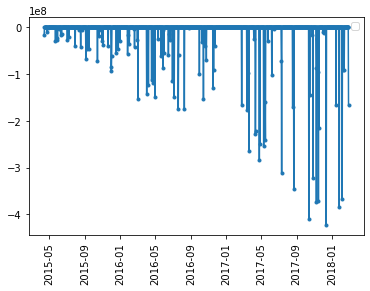

In [19]:
# 整体规律
plot_data = cashflow_data[ (cashflow_data['cashflow_subcategory']=='invest') & 
                         (cashflow_data['branch_id']==sample_branch)
                         ].sort_values('date')

# 不是每天都有数据。为了更好得可视化数据的规律，没有数据的地方有0填充
full_data = pd.DataFrame({'date':pd.date_range( plot_data['date'].min(), plot_data['date'].max() )})
plot_data = pd.merge( full_data, plot_data[['date', 'cashflow']], how='left' )
plot_data.fillna(0, inplace=True)

plt.plot( plot_data['date'], plot_data['cashflow'], '.-' )
plt.xticks(rotation=90)
plt.legend()

结论：
1. invest本来就是项目决策的目标，所以不需要去做预测

### 1.5.6. invest & interest 数据的规律

No handles with labels found to put in legend.


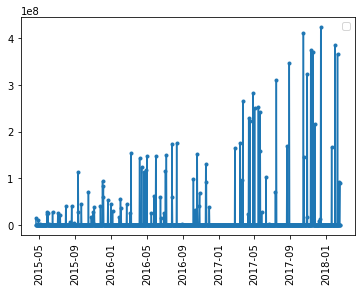

In [20]:
# 整体规律
plot_data = cashflow_data[ (cashflow_data['cashflow_subcategory']=='invest & interest') & 
                         (cashflow_data['branch_id']==sample_branch)
                         ].sort_values('date')

# 不是每天都有数据。为了更好得可视化数据的规律，没有数据的地方有0填充
full_data = pd.DataFrame({'date':pd.date_range( plot_data['date'].min(), plot_data['date'].max() )})
plot_data = pd.merge( full_data, plot_data[['date', 'cashflow']], how='left' )
plot_data.fillna(0, inplace=True)

plt.plot( plot_data['date'], plot_data['cashflow'], '.-' )
plt.xticks(rotation=90)
plt.legend()

结论：
1. 未来在什么时候可以有多少投资收益，可以由过去投资的记录（投资日期，投资期限，预计收益率）估算，不需要预测。

# 2. 特征工程

## 2.0. 大部分商业时间序列预测都会用到的日历数据

In [21]:
calendar = pd.read_csv('data/calendar.csv', parse_dates=['date'])
calendar.head(2)

,date,day_of_week,day_off,holiday
0,2015-01-01,4,1,NewYearsDay
1,2015-01-02,5,1,NewYearsDay


* day_off: 是否放假（包括周末和法定假日）, 1表示放假， 0表示不放假
* holiday: 法定节假日的名称
* 每年根据国务院最新的放假信息更新数据

In [22]:
# calendar中包含的节假日
calendar['holiday'].unique()

array(['NewYearsDay', nan, 'ChineseNewYearsEve', 'ChineseNewYear',
       'QingMing', 'LaborsDay', 'DragonBoatDay', 'MoonFestival',
       'NationalDay'], dtype=object)

## 2.1. 和sales预测有关的特征

In [23]:
#获取sales的历史数据
df_sales = cashflow_data[ cashflow_data['cashflow_subcategory']=='sales' 
                        ][['date','branch_id', 'cashflow']]

In [24]:
# 添加特征：是否是除夕
cnye_dates = calendar[ calendar['holiday']=='ChineseNewYearsEve'  ]['date'].values
df_sales.loc[:,'is_cnye'] = 0
df_sales.loc[ df_sales['date'].isin( cnye_dates ), 'is_cnye' ] = 1

In [25]:
#添加特征： 是否是年初一
cny1_dates = [ cnye+pd.Timedelta(1, unit='D') for cnye in cnye_dates ]
df_sales.loc[:,'is_cny1'] = 0
df_sales.loc[ df_sales['date'].isin( cny1_dates ), 'is_cny1' ] = 1

## 2.2. 和labor预测有关的特征

In [26]:
#获取labor的历史数据
df_labor = cashflow_data[ cashflow_data['cashflow_subcategory']=='labor' 
                        ][['date','branch_id', 'cashflow']]

In [27]:
#将没有数据的日期用0填补
full_data = df_sales[['branch_id','date']].copy()
df_labor = pd.merge( full_data, df_labor, how='left' )
df_labor.fillna(0, inplace=True)

In [28]:
#添加特征：是否是发薪日
#发薪日都是每月25号，如果25号是放假日，那么提前到上一个上班日

## step1: 找到每月的25日
calendar['month'] = calendar['date'] - pd.to_timedelta( calendar['date'].dt.day-1, unit='D' )
date_25 = calendar[ calendar['date'].dt.day==25 
                 ][['date','month']].rename(columns={'date':'date_25'})

## step2: 找到每月25日之前的所有上班日（含25日）
date_work = calendar[ calendar['day_off']==0 ][['date','month']].rename(columns={'date':'date_work'})
date_work = pd.merge( date_25, date_work )
date_work = date_work[ date_work['date_work'] <=  date_work['date_25'] ]


## step3: 找到距离25日最近的上班日，也就是日期最靠后的上班日，即为发薪日
pay_date = date_work.groupby( ['month'] )['date_work'].max().values

df_labor.loc[:, 'is_pay_date'] = 0
df_labor.loc[ df_labor['date'].isin( pay_date ), 'is_pay_date' ] = 1

## 2.3. 和material cost预测有关的特征

In [29]:
#获取material cost的历史数据
df_cost = cashflow_data[ cashflow_data['cashflow_subcategory']=='material cost' 
                        ][['date','branch_id', 'cashflow']]

In [30]:
#将没有数据的日期用0填补
full_data = df_sales[['branch_id','date']].copy()
df_cost = pd.merge( full_data, df_cost, how='left' )
df_cost.fillna(0, inplace=True)

In [31]:
#添加特征：是否是付款日
#每个季度的最后一天给供应商打款，如果那一天是节假日，那么提前到上一个上班日

## step1: 每个季度的最后一天
calendar['month'] = calendar['date'] - pd.to_timedelta( calendar['date'].dt.day-1, unit='D' )
season_end = calendar[ ((calendar['date'].dt.month== 3) & (calendar['date'].dt.day==31)) |
                      ((calendar['date'].dt.month== 6) & (calendar['date'].dt.day==30))|
                      ((calendar['date'].dt.month== 9) & (calendar['date'].dt.day==30))|
                      ((calendar['date'].dt.month== 12) & (calendar['date'].dt.day==31))
                     ][['date','month']].rename(columns={'date':'season_end'})

## step2: 找到季末之前的所有上班日（含付款日）
date_work = calendar[ calendar['day_off']==0 ][['date','month']].rename(columns={'date':'date_work'})
date_work = pd.merge( season_end, date_work )
date_work = date_work[ date_work['date_work'] <=  date_work['season_end'] ]

## step3: 找到距离季末最近的上班日，即为付款日
pay_date = date_work.groupby( ['month'] )['date_work'].max().values

df_cost.loc[:, 'is_pay_date'] = 0
df_cost.loc[ df_cost['date'].isin( pay_date ), 'is_pay_date' ] = 1

## 2.4. 和rent & utility预测有关的特征

In [32]:
#获取rent & utility的历史数据
df_rent = cashflow_data[ cashflow_data['cashflow_subcategory']=='rent & utility' 
                       ][['date','branch_id', 'cashflow']]

In [33]:
#将没有数据的日期用0填补
full_data = df_sales[['branch_id','date']].copy()
df_rent = pd.merge( full_data, df_rent, how='left' )
df_rent.fillna(0, inplace=True)

In [34]:
#添加特征：是否是支付房租的日期
#每个子公司会固定在一个月的某一天支付房租和其他花费。每个子公司不一样支付房租的日期不一样，有的是一个月的第几天，有的是倒数第几天
#需要根据每个子公司的历史付款日期，判断它是在每个月的第几天/或倒数第几天付款的

## step1: 给日期打上一个月第几天和一个月倒数第一天的标签
calendar['day_of_month'] = calendar['date'].dt.day
calendar['day_of_month_reverse'] = (calendar['date']+pd.tseries.offsets.MonthEnd(0) - calendar['date']).dt.days+1

## step2: 判断每个公司的房租日是否固定是每个月的第几天
pay_date1 = pd.merge( calendar[['date','day_of_month']],
                    df_rent[ df_rent['cashflow']!=0 ])
pay_date1 = pay_date1.groupby(['branch_id'])['day_of_month'].agg(['min','max']).reset_index()
pay_date1 = pay_date1[ pay_date1['min']==pay_date1['max'] 
                     ][['branch_id','min']].rename(columns={'min':'day_of_month'})
pay_date1 = pd.merge( pay_date1, calendar[['date','day_of_month']] )
pay_date1 = pay_date1[['branch_id','date']]
pay_date1['is_pay_date'] = 1

## step3: 判断每个公司的房租日是否固定是每个月的倒数几天
pay_date2 = pd.merge( calendar[['date','day_of_month_reverse']],
                     df_rent[ df_rent['cashflow']!=0 ])
pay_date2 = pay_date2.groupby(['branch_id'])['day_of_month_reverse'].agg(['min','max']).reset_index()
pay_date2 = pay_date2[ pay_date2['min']==pay_date2['max'] 
                     ][['branch_id','min']].rename(columns={'min':'day_of_month_reverse'})
pay_date2 = pd.merge( pay_date2, calendar[['date','day_of_month_reverse']] )
pay_date2 = pay_date2[['branch_id','date']]
pay_date2['is_pay_date'] = 1

## step4: 合并step2和step3的支付日期
pay_date = pd.concat( [pay_date1, pay_date2] )


df_rent = pd.merge( df_rent, pay_date, how='left' )
df_rent.fillna(0, inplace=True)

# 3 建模、测试、评价和优化

## 3.1. 小规模建模，目的是快速验证建模思路

In [35]:
# 用2016-12-31以前的数据做训练
cutoff_date = pd.to_datetime( '2016-12-31' )

#以sales最高的5号公司为例
sample_branch = 5

#往后预测1年
horizon = 365

### 3.1.1. 预测sales

In [36]:
#构建训练集和验证集
df_train = df_sales[ (df_sales['date'] <= cutoff_date) & 
                    (df_sales['branch_id'] == sample_branch)
                   ].sort_values('date')
df_train['ds'] = df_train['date']
df_train['y'] = df_train['cashflow']

df_val = df_sales[ (df_sales['date'] > cutoff_date) & 
                  (df_sales['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_sales['branch_id'] == sample_branch)
                 ].sort_values('date')
df_val['ds'] = df_val['date']
df_val['y'] = df_val['cashflow']

In [37]:
#用prophet建立模型
## 有yearly和weekly的周期性
## 用乘法周期性
## 加入除夕、年初一特征，特征的作用方式是乘法
## 要计算的是94%的置信区间（因为我们的目标是得到97%分位数）
## 其余超参数用prophet的默认值

m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=True,weekly_seasonality=True,interval_width=0.94 )
m.add_regressor( 'is_cnye', mode='multiplicative')
m.add_regressor( 'is_cny1', mode='multiplicative')

m.fit( df_train[['ds','y','is_cnye','is_cny1']] )

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
# 预测
forecast = m.predict( df_val[['ds','is_cnye', 'is_cny1']] )
df_val = pd.merge( df_val, 
                  forecast[['ds','yhat','yhat_lower','yhat_upper']]   )

In [39]:
# 计算94%置信区间的覆盖率
df_val['is_cover'] = 0
df_val.loc[ (df_val['y']<= df_val['yhat_upper']) & 
           (df_val['y']>=df_val['yhat_lower']), 'is_cover'] = 1
df_val['is_cover'].mean()

0.8547945205479452

覆盖率与目标比价接近，需要待后续再更多样本上做完测试后再决定是否需要优化。先move on到其他现金流类型的预测

### 3.1.2. 预测labor

In [40]:
#构建训练集和验证集
df_train = df_labor[ (df_labor['date'] <= cutoff_date) & 
                    (df_labor['branch_id'] == sample_branch)
                   ].sort_values('date')
df_train['ds'] = df_train['date']
df_train['y'] = df_train['cashflow']

df_val = df_labor[ (df_labor['date'] > cutoff_date) & 
                  (df_labor['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_labor['branch_id'] == sample_branch)
                 ].sort_values('date')
df_val['ds'] = df_val['date']
df_val['y'] = df_val['cashflow']

In [41]:
#用prophet建立模型
## 有yearly的周期性, 没有weekly的周期性
## 用乘法周期性
## 加入是否是付款日的特征，特征的作用方式是乘法
## 要计算的是94%的置信区间（因为我们的目标是得到97%分位数）
## 其余超参数用prophet的默认值

m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=True,weekly_seasonality=False,interval_width=0.94 )
m.add_regressor( 'is_pay_date', mode='multiplicative')
m.fit( df_train[['ds','y','is_pay_date']] )

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
# 预测
forecast = m.predict( df_val[['ds','is_pay_date']] )
df_val = pd.merge( df_val, 
                  forecast[['ds','yhat','yhat_lower','yhat_upper']])

In [43]:
# 计算94%置信区间的覆盖率
df_val['is_cover'] = 0
df_val.loc[ (df_val['y']<= df_val['yhat_upper']) & 
           (df_val['y']>=df_val['yhat_lower']), 'is_cover'] = 1
df_val['is_cover'].mean()

0.9917808219178083

覆盖率与目标比价接近，需要待后续再更多样本上做完测试后再决定是否需要优化。先move on到其他现金流类型的预测

### 3.1.3. 预测 material cost

In [44]:
#构建训练集和验证集
df_train = df_cost[ (df_cost['date'] <= cutoff_date) & 
                    (df_cost['branch_id'] == sample_branch)
                   ].sort_values('date')
df_train['ds'] = df_train['date']
df_train['y'] = df_train['cashflow']

df_val = df_cost[ (df_cost['date'] > cutoff_date) & 
                  (df_cost['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_cost['branch_id'] == sample_branch)
                 ].sort_values('date')
df_val['ds'] = df_val['date']
df_val['y'] = df_val['cashflow']

In [45]:
#用prophet建立模型
## 没有yearly的周期性, 没有weekly的周期性
## 用乘法周期性
## 加入是否是付款日的特征，特征的作用方式是乘法
## 要计算的是94%的置信区间（因为我们的目标是得到97%分位数）
## 其余超参数用prophet的默认值

m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=False,weekly_seasonality=False,interval_width=0.94 )
m.add_regressor( 'is_pay_date', mode='multiplicative')
m.fit( df_train[['ds','y','is_pay_date']] )

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
# 预测
forecast = m.predict( df_val[['ds','is_pay_date']] )
df_val = pd.merge( df_val, 
                  forecast[['ds','yhat','yhat_upper','yhat_lower']]  )

In [47]:
# 计算94%置信区间的覆盖率
df_val['is_cover'] = 0
df_val.loc[ (df_val['y']<= df_val['yhat_upper']) & 
           (df_val['y']>=df_val['yhat_lower']), 'is_cover'] = 1
df_val['is_cover'].mean()

0.989041095890411

覆盖率与目标比价接近，需要待后续再更多样本上做完测试后再决定是否需要优化。先move on到其他现金流类型的预测

### 3.1.4. 预测 rent & utility

In [48]:
#构建训练集和验证集
df_train = df_rent[ (df_rent['date'] <= cutoff_date) & 
                    (df_rent['branch_id'] == sample_branch)
                   ].sort_values('date')
df_train['ds'] = df_train['date']
df_train['y'] = df_train['cashflow']

df_val = df_rent[ (df_rent['date'] > cutoff_date) & 
                  (df_rent['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_rent['branch_id'] == sample_branch)
                 ].sort_values('date')
df_val['ds'] = df_val['date']
df_val['y'] = df_val['cashflow']

In [49]:
#用prophet建立模型
## 没有yearly的周期性, 没有weekly的周期性
## 用乘法周期性
## 加入是否是付款日的特征，特征的作用方式是乘法
## 要计算的是94%的置信区间（因为我们的目标是得到97%分位数）
## 其余超参数用prophet的默认值

m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=False,weekly_seasonality=False,interval_width=0.94 )
m.add_regressor( 'is_pay_date', mode='multiplicative')
m.fit( df_train[['ds','y','is_pay_date']] )

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
# 预测
forecast = m.predict( df_val[['ds','is_pay_date']] )
df_val = pd.merge( df_val, 
                  forecast[['ds','yhat','yhat_upper','yhat_lower']]  )

In [51]:
# 计算94%置信区间的覆盖率
df_val['is_cover'] = 0
df_val.loc[ (df_val['y']<= df_val['yhat_upper']) & 
           (df_val['y']>=df_val['yhat_lower']), 'is_cover'] = 1
df_val['is_cover'].mean()

1.0

覆盖率与目标比价接近，需要待后续再更多样本上做完测试后再决定是否需要优化。先move on到其他现金流类型的预测

## 3.2. 大规模测试，目的是为了得到确定的模型效果 

In [52]:
# 对所有子公司都做测试

# 用2016-12-31以前的数据做训练
# 实际上应该设置多个cutoff_date, 用back test的方式做多几轮测试。这里为了节约时间，先只做一个时间点的测试
cutoff_date = pd.to_datetime( '2016-12-31' )
#往后预测365天 （设1周是为了缩短运行时间， 实际上需要设365天）
horizon = 365

val_results = []
branch_id_list = cashflow_data['branch_id'].unique()
for tmp_branch_id in branch_id_list: #对子公司做循环
    
    # 测试sales
    df_train = df_sales[ df_sales['branch_id']==tmp_branch_id ]
    df_train['ds'] = df_train['date']
    df_train['y'] = df_train['cashflow']
    
    m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=True,weekly_seasonality=True,interval_width=0.94 )
    m.add_regressor( 'is_cnye', mode='multiplicative')
    m.add_regressor( 'is_cny1', mode='multiplicative')
    m.fit( df_train[['ds','y','is_cnye','is_cny1']] )
    
    df_val = df_sales[ (df_sales['date'] > cutoff_date) & 
                  (df_sales['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_sales['branch_id'] == tmp_branch_id)
                 ].sort_values('date')
    df_val['ds'] = df_val['date']
    df_val['y'] = df_val['cashflow']
    forecast = m.predict( df_val[['ds','is_cnye','is_cny1']] )
    df_val = pd.merge( df_val, 
                      forecast[['ds','yhat','yhat_upper','yhat_lower']]  )
    df_val['subcat'] = 'sales'
    val_results.append( df_val )
    
    # 测试labor
    df_train = df_labor[ df_labor['branch_id']==tmp_branch_id ]
    df_train['ds'] = df_train['date']
    df_train['y'] = df_train['cashflow']
    m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=True,weekly_seasonality=False,interval_width=0.94 )
    m.add_regressor( 'is_pay_date', mode='multiplicative')
    m.fit( df_train[['ds','y','is_pay_date']] )
    
    df_val = df_labor[ (df_labor['date'] > cutoff_date) & 
                  (df_labor['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_labor['branch_id'] == tmp_branch_id)
                 ].sort_values('date')
    df_val['ds'] = df_val['date']
    df_val['y'] = df_val['cashflow']
    forecast = m.predict( df_val[['ds','is_pay_date']] )
    df_val = pd.merge( df_val, 
                      forecast[['ds','yhat','yhat_upper','yhat_lower']]   )
    df_val['subcat'] = 'labor'
    val_results.append( df_val )
    
    # 测试material cost
    df_train = df_cost[ df_cost['branch_id']==tmp_branch_id ]
    df_train['ds'] = df_train['date']
    df_train['y'] = df_train['cashflow']
    m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=False,weekly_seasonality=False,interval_width=0.94 )
    m.add_regressor( 'is_pay_date', mode='multiplicative')
    m.fit( df_train[['ds','y','is_pay_date']] )
    
    df_val = df_cost[ (df_cost['date'] > cutoff_date) & 
                  (df_cost['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_cost['branch_id'] == tmp_branch_id)
                 ].sort_values('date')
    df_val['ds'] = df_val['date']
    df_val['y'] = df_val['cashflow']
    forecast = m.predict( df_val[['ds','is_pay_date']] )
    df_val = pd.merge( df_val, 
                      forecast[['ds','yhat','yhat_upper','yhat_lower']]   )
    df_val['subcat'] = 'cost'
    val_results.append( df_val )
    
    
    # 测试rent
    df_train = df_rent[ df_rent['branch_id']==tmp_branch_id ]
    df_train['ds'] = df_train['date']
    df_train['y'] = df_train['cashflow']
    m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=False,weekly_seasonality=False,interval_width=0.94 )
    m.add_regressor( 'is_pay_date', mode='multiplicative')
    m.fit( df_train[['ds','y','is_pay_date']] )
    df_val = df_rent[ (df_rent['date'] > cutoff_date) & 
                  (df_rent['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_rent['branch_id'] == tmp_branch_id)
                 ].sort_values('date')
    df_val['ds'] = df_val['date']
    df_val['y'] = df_val['cashflow']
    forecast = m.predict( df_val[['ds','is_pay_date']] )
    df_val = pd.merge( df_val, 
                      forecast[['ds','yhat','yhat_upper','yhat_lower']]   )
    df_val['subcat'] = 'rent'
    val_results.append( df_val )
    

val_results = pd.concat( val_results )

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
#val_results = pd.read_csv('val_result.csv')

In [54]:
val_results['is_cover'] = 0
val_results.loc[ (val_results['y']<=val_results['yhat_upper']) & 
                (val_results['y']>=val_results['yhat_lower']), 'is_cover' ] = 1

In [55]:
val_results['is_cover'].mean()

0.9715808170515098

## 3.3. 误差分析，寻找优化的机会点

In [56]:
# 是不是某一些现金流类型表现得比较差
eval_by_subcat = val_results.groupby(['subcat'])['is_cover'].mean().reset_index()
eval_by_subcat

,subcat,is_cover
0,cost,0.990453
1,labor,0.972913
2,rent,0.990231
3,sales,0.932726


In [57]:
# 是不是某一些公司表现得特别差
eval_by_branch = val_results[val_results['subcat']=='sales'
                           ].groupby(['branch_id'])['is_cover'].mean().reset_index()
eval_by_branch = eval_by_branch.sort_values('is_cover')
eval_by_branch

,branch_id,is_cover
6,7,0.901370
9,10,0.928767
10,11,0.928767
0,1,0.931507
1,2,0.934247
3,4,0.934247
5,6,0.934247
7,8,0.934247
11,12,0.934247
13,14,0.934247


In [58]:
# 是不是某些日期表现得特别差
eval_by_date = val_results[val_results['subcat']=='sales'
                           ].groupby(['date'])['is_cover'].mean().reset_index()
eval_by_date = eval_by_date.sort_values('is_cover')
eval_by_date

,date,is_cover
41,2017-02-11,0.000000
23,2017-01-24,0.000000
22,2017-01-23,0.000000
42,2017-02-12,0.000000
148,2017-05-29,0.000000
149,2017-05-30,0.000000
151,2017-06-01,0.000000
29,2017-01-30,0.000000
30,2017-01-31,0.000000
24,2017-01-25,0.000000


结论：
法定节假日对sales的结果有很大的影响，需要加入到特征中

## 3.4. 模型优化

In [59]:
# 以优化sales为例
# 添加节假日特征
holiday_list = list( calendar[ ~calendar['holiday'].isna() ]['holiday'].unique() )
for col in holiday_list:
    holiday_dates = calendar[ calendar['holiday']==col ]['date'].values
    
    df_sales[ col ] = 0
    df_sales.loc[ df_sales['date'].isin( holiday_dates ), col ] = 1
df_sales.head(2)

,date,branch_id,cashflow,is_cnye,is_cny1,NewYearsDay,ChineseNewYearsEve,ChineseNewYear,QingMing,LaborsDay,DragonBoatDay,MoonFestival,NationalDay
0,2015-04-01,1,275765.184075,0,0,0,0,0,0,0,0,0,0
1,2015-04-02,1,255256.272380,0,0,0,0,0,0,0,0,0,0


In [60]:
# 对sales预测再次进行测试
sales_val_results = []
branch_id_list = cashflow_data['branch_id'].unique()
for tmp_branch_id in branch_id_list: #对子公司做循环
    
    # 测试sales
    df_train = df_sales[ df_sales['branch_id']==tmp_branch_id ]
    df_train['ds'] = df_train['date']
    df_train['y'] = df_train['cashflow']
    
    m = Prophet( seasonality_mode='multiplicative', yearly_seasonality=True,weekly_seasonality=True,interval_width=0.94 )
    for col in ['is_cny1'] + holiday_list:
        m.add_regressor(  col , mode='multiplicative')
    m.fit( df_train[['ds','y','is_cny1'] + holiday_list ] )
    
    df_val = df_sales[ (df_sales['date'] > cutoff_date) & 
                  (df_sales['date'] <= cutoff_date + pd.Timedelta( horizon, unit='D' )  ) & 
                  (df_sales['branch_id'] == tmp_branch_id)
                 ].sort_values('date')
    df_val['ds'] = df_val['date']
    df_val['y'] = df_val['cashflow']
    forecast = m.predict( df_val[['ds','is_cny1'] + holiday_list] )
    df_val = pd.merge( df_val, 
                      forecast[['ds','yhat','yhat_upper','yhat_lower']]  )
    df_val['subcat'] = 'sales'
    sales_val_results.append( df_val )
    

sales_val_results = pd.concat( sales_val_results )

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [61]:
#sales_val_results = pd.read_csv('sales_val_result.csv')

In [62]:
sales_val_results['is_cover'] = 0
sales_val_results.loc[ (sales_val_results['y']<=sales_val_results['yhat_upper']) & 
                      (sales_val_results['y']>=sales_val_results['yhat_lower']), 'is_cover' ] = 1

In [63]:
eval_by_subcat = sales_val_results.groupby(['subcat'])['is_cover'].mean().reset_index()
eval_by_subcat

,subcat,is_cover
0,sales,0.940941
